In [ ]:
import numpy as np
import torch
import torch.nn as nn
import scipy
from scipy.io import loadmat
import librosa
from glob import glob
import pandas as pd
import os
import shutil
from random import shuffle
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from pathlib import Path
from scipy.stats import pearsonr 
from torch.nn.functional import normalize
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


In [ ]:
!unzip *.zip

In [ ]:
mat_path = '/content/EmaClean'
wav_path = '/content/WavClean'
filenames = sorted([f[:-4] for f in os.listdir(wav_path) if f.endswith('.wav')])


In [ ]:
wav_path = '/content/WavClean'
mat_path = '/content/EmaClean'

wav_train_path = 'data/wav_train'
mat_train_path = 'data/mat_train'

wav_test_path = 'data/wav_test'
mat_test_path = 'data/mat_test'

wav_validation_path = 'data/wav_validation'
mat_validation_path = 'data/mat_validation'

if not os.path.exists(wav_train_path):
  os.makedirs(wav_train_path)

if not os.path.exists(wav_validation_path):
  os.makedirs(wav_validation_path)

if not os.path.exists(wav_test_path):
  os.makedirs(wav_test_path)

if not os.path.exists(mat_train_path):
  os.makedirs(mat_train_path)

if not os.path.exists(mat_validation_path):
  os.makedirs(mat_validation_path)

if not os.path.exists(mat_test_path):
  os.makedirs(mat_test_path)



In [ ]:
test_filenames = [f for f in filenames if int(f[-1] == '0')]
validation_filenames = [f for f in filenames if int(f[-1] == '1')]
exclude_set1 = set(test_filenames)
exclude_set2 = set(validation_filenames)
main_set = set(filenames)
train_set = main_set - exclude_set1 - exclude_set2
train_filenames = list(train_set)

for filename in test_filenames:
  wav = os.path.join(wav_path, filename + '.wav')
  mat = os.path.join(mat_path, filename + '.mat')
  shutil.copy(wav, os.path.join(wav_test_path, os.path.basename(wav)))
  shutil.copy(mat, os.path.join(mat_test_path, os.path.basename(mat)))
  #folder = os.listdir(mat_test_path)
  #for i in folder:
    #print(i)
for filename in validation_filenames:
  wav = os.path.join(wav_path, filename + '.wav')
  mat = os.path.join(mat_path, filename + '.mat')
  shutil.copy(wav, os.path.join(wav_validation_path, os.path.basename(wav)))
  shutil.copy(mat, os.path.join(mat_validation_path, os.path.basename(mat)))

for filename in train_filenames:
  wav = os.path.join(wav_path, filename + '.wav')
  mat = os.path.join(mat_path, filename + '.mat')
  shutil.copy(wav, os.path.join(wav_train_path, os.path.basename(wav)))
  shutil.copy(mat, os.path.join(mat_train_path, os.path.basename(mat)))


mat_files = os.listdir('/content/data/mat_train')
points = []


for i, mat_file in enumerate(mat_files):
    m = scipy.io.loadmat(os.path.join('/content/data/mat_train', mat_file))
    ema_data = m['EmaData']
    ema = torch.tensor(ema_data)
    indices = torch.tensor([12,13,14,15,16,17])
    target = torch.index_select(ema, 0, indices)
    hulls = []
    for j in range(3):
        x = target[2*j, :]
        y = target[2*j + 1, :]
        points.append(np.vstack((x,y)).T)      

points = np.vstack(points)
hull =  ConvexHull(points)
x_all = []
y_all = []
for simplex in hull.simplices:
    x_c = points[simplex,0]
    y_c = points[simplex,1]
    index = np.where((y_c>1) & (x_c>-48))
    x_c_f = x_c[index]           
    y_c_f = y_c[index]
    #plt.plot(x_c_f, y_c_f, 'r-', lw = 2) 

    for x, y in zip(x_c_f, y_c_f):
        if x not in x_all:
            x_all.append(x)
            y_all.append(y)           

sorted_indices = np.argsort(x_all)
x_all = np.array(x_all)[sorted_indices]
y_all = np.array(y_all)[sorted_indices]



In [ ]:
class CustDat(Dataset):
  
  def __init__(self, mat_path, wav_path, sr = 16000, window_size = 1024, hop_length = 160, n_mfcc = 13):
    self.mat_path = mat_path
    self.wav_path = wav_path
    self.sr = sr
    self.window_size = window_size
    self.hop_length = hop_length    
    self.n_mfcc = n_mfcc
    self.filenames = sorted([f[:-4] for f in os.listdir(wav_path) if f.endswith('.wav')])
    self.wav_path = Path(wav_path)
    self.mat_path = Path(mat_path)
   
  
  def __len__(self):
    
    return len(self.filenames)
  
  def __getitem__(self, idx):
    
    filename = self.filenames[idx]
    wav_file = self.wav_path / (filename + '.wav')
    raw_data, sr = librosa.load(wav_file, sr=self.sr)
    mat_file = self.mat_path / (filename + '.mat')
    target_data = loadmat(mat_file)['EmaData']
    
    mfcc = librosa.feature.mfcc(raw_data, sr = self.sr, n_fft = self.window_size, hop_length = self.hop_length, n_mfcc = self.n_mfcc)
    target = torch.tensor(target_data)
        
    

    n_ema = target.shape[1]
    n_mfcc = mfcc.shape[1]
    if n_mfcc < n_ema:
       mfcc_padded = np.zeros((13, n_ema))
       mfcc_padded[:, :n_mfcc] = mfcc
       mfcc = mfcc_padded
    else:
       mfcc = mfcc[:, :n_ema]

    mfcc = torch.tensor(mfcc.T)
    indices = torch.tensor([0,1,2,3,8,9,12,13,14,15,16,17])
    target = torch.index_select(target, 0, indices)
    #target_data_mean = np.mean(target, axis = 1)
    #target_data_std = np.std(target, axis=1)
    #target_mean = torch.tensor(target_data_mean)
    #target_std = torch.tensor(target_data_std)
    
    target_mean = torch.mean(target, axis = 1)
    target_std = torch.std(target, axis=1)
    for i in range (12):
      target[i] = (target[i]-target_mean[i]) / target_std[i]

    target_val = torch.tensor(target.T)
    return target_val, mfcc

    
 





In [ ]:
#CustDat(mat_train_path, wav_train_path).__getitem__(0)

In [ ]:
class CollateFn:
  def __call__(sel, batch):
    emas, mfccs = zip(*batch)
    max_frames_emas = max([e.shape[0] for e in emas])
    max_frames_mfccs = max([mfcc.shape[0] for mfcc in mfccs])
    ema_pad = torch.zeros(len(emas), max_frames_emas, emas[0].shape[1])
    mfcc_pad = torch.zeros(len(mfccs), max_frames_mfccs, mfccs[0].shape[1])
    for i, ema in enumerate(emas):
      ema_pad[i, :ema.shape[0],:] = ema
    for i, mfcc in enumerate(mfccs):  
      mfcc_pad[i, :mfcc.shape[0],:] = mfcc

    return ema_pad, mfcc_pad

In [ ]:
train_dl = DataLoader(CustDat(mat_train_path, wav_train_path),collate_fn = CollateFn(), batch_size = 16, shuffle = False)
val_dl = DataLoader(CustDat(mat_validation_path, wav_validation_path),collate_fn = CollateFn(), batch_size = 16, shuffle = False)
test_dl = DataLoader(CustDat(mat_test_path, wav_test_path), collate_fn = CollateFn(), batch_size = 16, shuffle = False)


<ipython-input-15-c75df663cd2c>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_val = torch.tensor(target.T)


Epoch [1/10], train_loss:4.3459, train_correlation_coefficient:0.0741, validation_loss:3.7794, validation_correlation_coefficient:0.1370, test_loss:3.4463, test_correlation_coefficient:0.1191
Epoch [2/10], train_loss:1.7911, train_correlation_coefficient:0.1251, validation_loss:1.6599, validation_correlation_coefficient:0.1829, test_loss:1.4776, test_correlation_coefficient:0.1844
Epoch [3/10], train_loss:1.4637, train_correlation_coefficient:0.1918, validation_loss:1.3864, validation_correlation_coefficient:0.2330, test_loss:1.2430, test_correlation_coefficient:0.2564
Epoch [4/10], train_loss:1.3631, train_correlation_coefficient:0.2476, validation_loss:1.2812, validation_correlation_coefficient:0.2755, test_loss:1.1411, test_correlation_coefficient:0.3067
Epoch [5/10], train_loss:1.3056, train_correlation_coefficient:0.2903, validation_loss:1.2237, validation_correlation_coefficient:0.3085, test_loss:1.0848, test_correlation_coefficient:0.3433
Epoch [6/10], train_loss:1.2604, train_c

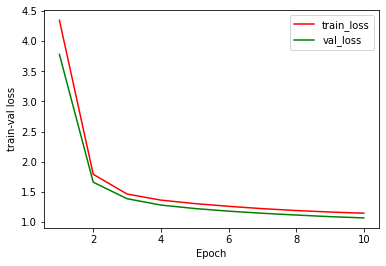

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
  
        self.layer1 = nn.Conv1d(in_channels = 13, out_channels = 32, kernel_size = 3, padding = 1)
        self.layer2 = nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.layer3 = nn.Conv1d(in_channels = 64, out_channels = 256, kernel_size = 3, padding = 1)
        self.layer4 = nn.Conv1d(in_channels = 256, out_channels = 12, kernel_size = 3, padding = 1)
        self.relu = torch.nn.ReLU()       

    def forward(self, x):
      x = x.permute(0,2,1)
      x = self.layer1(x)
      x = self.relu(x)
      x = self.layer2(x)
      x = self.relu(x)
      x = self.layer3(x)
      x = self.relu(x)
      x = self.layer4(x)
      x = x.permute(0,2,1)

      return x

model = Net()
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
epochs = 10
mean_train_pearsonr = 0
mean_val_pearsonr = 0 
mean_test_pearsonr = 0
mean_co_train = []
mean_co_val = []
mean_co_test = []
TL = []
VL = []


model.train()
for epoch in range (epochs):
  train_loss = 0
  for emma, mfcc in train_dl:
    model = model.float()
    emma = emma.float()
    mfcc = mfcc.float()
    optimizer.zero_grad()
    outputs = model(mfcc)
    train_loss = loss(outputs, emma)
    pred_ema = outputs.detach()
    true_ema = emma.detach()
    correlations = []
    for i in range(pred_ema.shape[2]):
      corr,_ = pearsonr(true_ema[0,:,i], pred_ema[0,:,i])
      correlations.append(corr)
    mean_corr = np.mean(correlations)
    mean_co_train.append(mean_corr)             
    train_loss.backward()
    optimizer.step()
    train_loss += train_loss.item()

 
  model.eval()
  validation_loss=0
  with torch.no_grad():
   for emma, mfcc in val_dl:
     model = model.float()
     emma = emma.float()
     mfcc = mfcc.float()
     outputs = model(mfcc)
     validation_loss = loss(outputs, emma)
     pred_ema = outputs.detach()
     true_ema = emma.detach()
     correlations = []
     for i in range(pred_ema.shape[2]):
       corr,_ = pearsonr(true_ema[0,:,i], pred_ema[0,:,i])
       correlations.append(corr)
     mean_corr = np.mean(correlations)
     mean_co_val.append(mean_corr)
     validation_loss += validation_loss.item()
    
  test_loss = 0
  with torch.no_grad():
   for emma, mfcc in test_dl:
     model = model.float()
     emma = emma.float()
     mfcc = mfcc.float()
     outputs = model(mfcc)
     test_loss = loss(outputs, emma)
     pred_ema = outputs.detach()
     true_ema = emma.detach()
     correlations = []
     for i in range(pred_ema.shape[2]):
       corr,_ = pearsonr(true_ema[0,:,i], pred_ema[0,:,i])
       correlations.append(corr)
     mean_corr = np.mean(correlations)
     mean_co_test.append(mean_corr)
     test_loss += test_loss.item()
  
  mean_train_pearsonr = np.mean(mean_co_train)   
  mean_val_pearsonr = np.mean(mean_co_val)  
  mean_test_pearsonr = np.mean(mean_co_test)  
  

  
  print('Epoch [{}/{}], train_loss:{:.4f}, train_correlation_coefficient:{:.4f}, validation_loss:{:.4f}, validation_correlation_coefficient:{:.4f}, test_loss:{:.4f}, test_correlation_coefficient:{:.4f}'.format(epoch+1, epochs, train_loss, mean_train_pearsonr, validation_loss, mean_val_pearsonr,  test_loss, mean_test_pearsonr))
  TL.append(train_loss)
  VL.append(validation_loss)

print(len(TL))
with torch.no_grad():
   ep = range(1, epochs+1)
   plt.plot(ep, TL, color = 'r', label = 'train_loss' )
   plt.plot(ep, VL, color = 'g', label = 'val_loss' )
   plt.xlabel('Epoch')
   plt.ylabel('train-val loss')
   plt.legend()
   plt.show()




os.makedirs('path/to/directory' , exist_ok = True)
torch.save(model.state_dict(), 'path/to/directory/model.pth')





In [ ]:
CH = [-45.23562205, -42.21695848, -40.00809952, -25.05182801, -17.31076902, -3.79376159, -0.38335141, 16.29013896, 18.67840768, 20.18741574, 21.64881282, 18.64411811, 9.12052052, 1.45907601]
mean = sum(CH) / len(CH)
std = (sum([(x - mean) ** 2 for x in CH]) / len(CH)) ** 0.5
CH_std = [(x - mean) / std for x in CH]
convex_hull = np.tile(CH_std, (16,1,1))
convex_hull = convex_hull.reshape((16,14))



<ipython-input-7-c75df663cd2c>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_val = torch.tensor(target.T)


Epoch [1/5], emma_train_loss:5.0966, emma_train_correlation_coefficient:-0.0041, Convex_hull_train_loss:0.8193, emma_validation_loss:4.7657, emma_validation_correlation_coefficient:0.0100, Convex_hull_val_loss:0.9680, emma_test_loss:4.7657, emma_test_correlation_coefficient:0.0100, Convex_hull_test_loss:0.9680
Epoch [2/5], emma_train_loss:2.1413, emma_train_correlation_coefficient:0.0250, Convex_hull_train_loss:0.1240, emma_validation_loss:2.1043, emma_validation_correlation_coefficient:0.0493, Convex_hull_val_loss:0.1263, emma_test_loss:2.1043, emma_test_correlation_coefficient:0.0493, Convex_hull_test_loss:0.1263
Epoch [3/5], emma_train_loss:1.7021, emma_train_correlation_coefficient:0.0736, Convex_hull_train_loss:0.0672, emma_validation_loss:1.6921, emma_validation_correlation_coefficient:0.1133, Convex_hull_val_loss:0.0665, emma_test_loss:1.6921, emma_test_correlation_coefficient:0.1133, Convex_hull_test_loss:0.0665
Epoch [4/5], emma_train_loss:1.5341, emma_train_correlation_coeffi

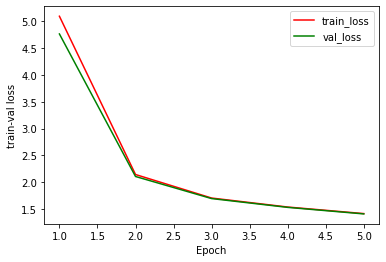

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
  
        self.layer1 = nn.Conv1d(in_channels = 13, out_channels = 32, kernel_size = 3, padding = 1)
        self.layer2 = nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.layer3 = nn.Conv1d(in_channels = 64, out_channels = 256, kernel_size = 3, padding = 1)
        self.layer4 = nn.Conv1d(in_channels = 256, out_channels = 12, kernel_size = 3, padding = 1)
        self.layer5 = nn.Linear(in_features=256, out_features=14)
        self.relu = torch.nn.ReLU()
        
             

    def forward(self, x):
      x = x.permute(0,2,1)
      x = self.layer1(x)
      x = self.relu(x)
      x = self.layer2(x)
      x = self.relu(x)
      x = self.layer3(x)
      x = self.relu(x)
      emma = self.layer4(x)
      x = torch.mean(x, dim=2)
      x = self.layer5(x)
      emma = emma.permute(0, 2, 1)
      return emma, x

model = Net()
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
epochs = 5
mean_train_pearsonr = 0
mean_val_pearsonr = 0 
mean_test_pearsonr = 0
mean_co_train = []
mean_co_val = []
mean_co_test = []
TL = []
VL = []



for epoch in range (epochs):
  model.train()
  train_emma_loss = 0
  train_convex_hull_loss = 0
  for emma, mfcc in train_dl:
    model = model.float()
    emma = emma.float()
    mfcc = mfcc.float()
    optimizer.zero_grad()
    emma_pred, convex_hull_pred = model(mfcc)

    train_emma_loss = loss(emma_pred, emma)
    train_convex_hull_loss = loss(convex_hull_pred, torch.Tensor(convex_hull))
    t_loss = train_emma_loss + train_convex_hull_loss
    pred_ema = emma_pred.detach()
    true_ema = emma.detach()
    correlations = []
    for i in range(pred_ema.shape[2]):
      corr,_ = pearsonr(true_ema[0,:,i], pred_ema[0,:,i])
      correlations.append(corr)
    mean_corr = np.mean(correlations)
    mean_co_train.append(mean_corr)  
    t_loss.backward()
    optimizer.step()
    train_emma_loss += train_emma_loss.item()
    train_convex_hull_loss += train_convex_hull_loss.item()


  model.eval()  
  val_emma_loss = 0
  val_convex_hull_loss = 0
  with torch.no_grad():
     for emma, mfcc in train_dl:
        model = model.float()
        emma = emma.float()
        mfcc = mfcc.float()
        optimizer.zero_grad()
        emma_pred, convex_hull_pred = model(mfcc)

        val_emma_loss = loss(emma_pred, emma)
        val_convex_hull_loss = loss(convex_hull_pred, torch.Tensor(convex_hull))
        t_loss = val_emma_loss + val_convex_hull_loss
        pred_ema = emma_pred.detach()
        true_ema = emma.detach()
        correlations = []
        for i in range(pred_ema.shape[2]):
            corr,_ = pearsonr(true_ema[0,:,i], pred_ema[0,:,i])
            correlations.append(corr)
        mean_corr = np.mean(correlations)
        mean_co_val.append(mean_corr)  
        val_emma_loss += val_emma_loss.item()
        val_convex_hull_loss += val_convex_hull_loss.item()

  test_emma_loss = 0
  test_convex_hull_loss = 0
  with torch.no_grad():
     for emma, mfcc in train_dl:
        model = model.float()
        emma = emma.float()
        mfcc = mfcc.float()
        optimizer.zero_grad()
        emma_pred, convex_hull_pred = model(mfcc)

        test_emma_loss = loss(emma_pred, emma)
        test_convex_hull_loss = loss(convex_hull_pred, torch.Tensor(convex_hull))
        t_loss = test_emma_loss + test_convex_hull_loss
        pred_ema = emma_pred.detach()
        true_ema = emma.detach()
        correlations = []
        for i in range(pred_ema.shape[2]):
            corr,_ = pearsonr(true_ema[0,:,i], pred_ema[0,:,i])
            correlations.append(corr)
        mean_corr = np.mean(correlations)
        mean_co_test.append(mean_corr)  
        test_emma_loss += test_emma_loss.item()
        test_convex_hull_loss += test_convex_hull_loss.item()
    
  
  mean_train_pearsonr = np.mean(mean_co_train)   
  mean_val_pearsonr = np.mean(mean_co_val)  
  mean_test_pearsonr = np.mean(mean_co_test)  
  

  
  print('Epoch [{}/{}], emma_train_loss:{:.4f}, emma_train_correlation_coefficient:{:.4f}, Convex_hull_train_loss:{:.4f}, emma_validation_loss:{:.4f}, emma_validation_correlation_coefficient:{:.4f}, Convex_hull_val_loss:{:.4f}, emma_test_loss:{:.4f}, emma_test_correlation_coefficient:{:.4f}, Convex_hull_test_loss:{:.4f}'.format(epoch+1, epochs, train_emma_loss, mean_train_pearsonr, train_convex_hull_loss, val_emma_loss, mean_val_pearsonr, val_convex_hull_loss, test_emma_loss, mean_test_pearsonr, test_convex_hull_loss))
  TL.append(train_emma_loss)
  VL.append(val_emma_loss)

print(len(TL))
with torch.no_grad():
   ep = range(1, epochs+1)
   plt.plot(ep, TL, color = 'r', label = 'train_loss' )
   plt.plot(ep, VL, color = 'g', label = 'val_loss' )
   plt.xlabel('Epoch')
   plt.ylabel('train-val loss')
   plt.legend()
   plt.show()



<ipython-input-7-c75df663cd2c>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_val = torch.tensor(target.T)


Epoch [1/50], emma_train_loss:2.3795, emma_train_correlation_coefficient:0.0124, Convex_hull_train_loss:0.1738, emma_validation_loss:2.2921, emma_validation_correlation_coefficient:0.0873, Convex_hull_val_loss:0.1795, emma_test_loss:2.2921, emma_test_correlation_coefficient:0.0873, Convex_hull_test_loss:0.1795


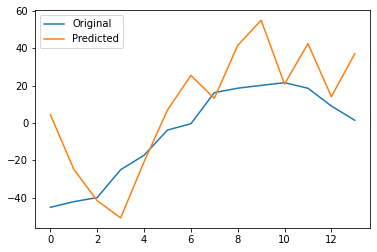

Epoch [2/50], emma_train_loss:1.5294, emma_train_correlation_coefficient:0.1083, Convex_hull_train_loss:0.0637, emma_validation_loss:1.5183, emma_validation_correlation_coefficient:0.2019, Convex_hull_val_loss:0.0595, emma_test_loss:1.5183, emma_test_correlation_coefficient:0.2019, Convex_hull_test_loss:0.0595


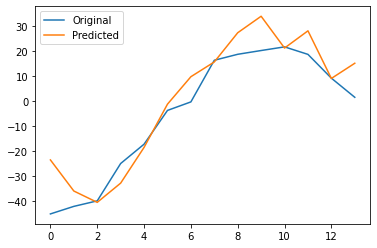

Epoch [3/50], emma_train_loss:1.3956, emma_train_correlation_coefficient:0.1943, Convex_hull_train_loss:0.0429, emma_validation_loss:1.3897, emma_validation_correlation_coefficient:0.2687, Convex_hull_val_loss:0.0430, emma_test_loss:1.3897, emma_test_correlation_coefficient:0.2687, Convex_hull_test_loss:0.0430


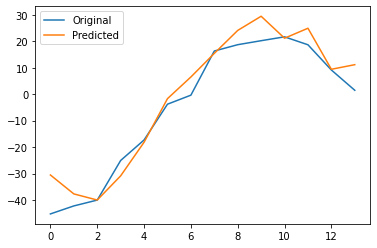

Epoch [4/50], emma_train_loss:1.3237, emma_train_correlation_coefficient:0.2526, Convex_hull_train_loss:0.0396, emma_validation_loss:1.3178, emma_validation_correlation_coefficient:0.3144, Convex_hull_val_loss:0.0397, emma_test_loss:1.3178, emma_test_correlation_coefficient:0.3144, Convex_hull_test_loss:0.0397


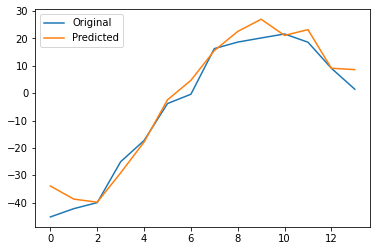

Epoch [5/50], emma_train_loss:1.2792, emma_train_correlation_coefficient:0.2958, Convex_hull_train_loss:0.0395, emma_validation_loss:1.2731, emma_validation_correlation_coefficient:0.3490, Convex_hull_val_loss:0.0397, emma_test_loss:1.2731, emma_test_correlation_coefficient:0.3490, Convex_hull_test_loss:0.0397


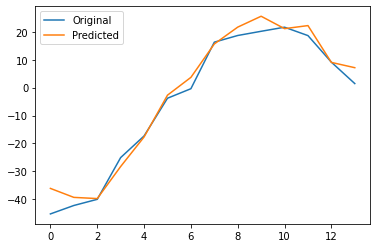

Epoch [6/50], emma_train_loss:1.2419, emma_train_correlation_coefficient:0.3296, Convex_hull_train_loss:0.0401, emma_validation_loss:1.2359, emma_validation_correlation_coefficient:0.3762, Convex_hull_val_loss:0.0403, emma_test_loss:1.2359, emma_test_correlation_coefficient:0.3762, Convex_hull_test_loss:0.0403


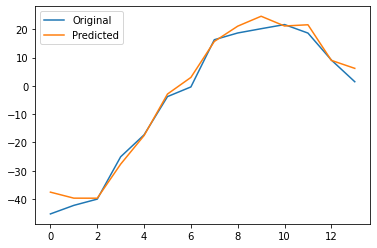

Epoch [7/50], emma_train_loss:1.2102, emma_train_correlation_coefficient:0.3570, Convex_hull_train_loss:0.0406, emma_validation_loss:1.2039, emma_validation_correlation_coefficient:0.3984, Convex_hull_val_loss:0.0407, emma_test_loss:1.2039, emma_test_correlation_coefficient:0.3984, Convex_hull_test_loss:0.0407


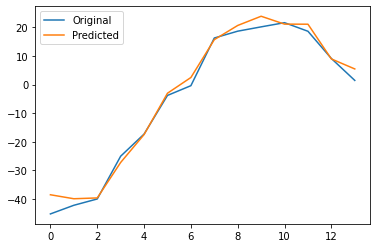

Epoch [8/50], emma_train_loss:1.1817, emma_train_correlation_coefficient:0.3797, Convex_hull_train_loss:0.0402, emma_validation_loss:1.1756, emma_validation_correlation_coefficient:0.4170, Convex_hull_val_loss:0.0404, emma_test_loss:1.1756, emma_test_correlation_coefficient:0.4170, Convex_hull_test_loss:0.0404


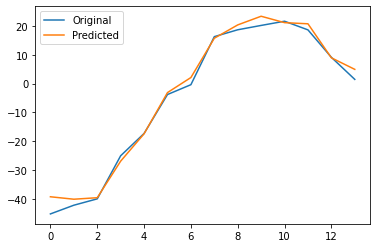

Epoch [9/50], emma_train_loss:1.1565, emma_train_correlation_coefficient:0.3990, Convex_hull_train_loss:0.0399, emma_validation_loss:1.1505, emma_validation_correlation_coefficient:0.4330, Convex_hull_val_loss:0.0400, emma_test_loss:1.1505, emma_test_correlation_coefficient:0.4330, Convex_hull_test_loss:0.0400


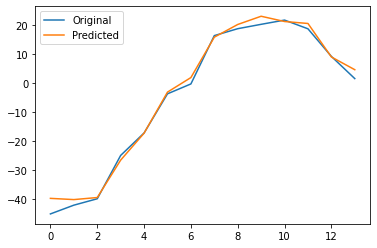

Epoch [10/50], emma_train_loss:1.1339, emma_train_correlation_coefficient:0.4158, Convex_hull_train_loss:0.0396, emma_validation_loss:1.1279, emma_validation_correlation_coefficient:0.4469, Convex_hull_val_loss:0.0398, emma_test_loss:1.1279, emma_test_correlation_coefficient:0.4469, Convex_hull_test_loss:0.0398


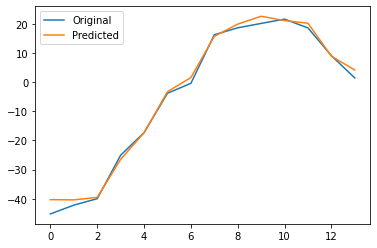

Epoch [11/50], emma_train_loss:1.1129, emma_train_correlation_coefficient:0.4305, Convex_hull_train_loss:0.0392, emma_validation_loss:1.1073, emma_validation_correlation_coefficient:0.4593, Convex_hull_val_loss:0.0395, emma_test_loss:1.1073, emma_test_correlation_coefficient:0.4593, Convex_hull_test_loss:0.0395


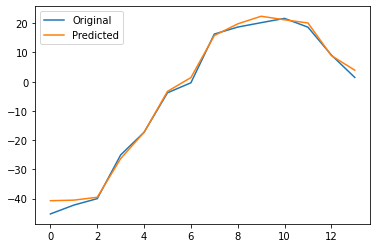

Epoch [12/50], emma_train_loss:1.0947, emma_train_correlation_coefficient:0.4436, Convex_hull_train_loss:0.0386, emma_validation_loss:1.0900, emma_validation_correlation_coefficient:0.4702, Convex_hull_val_loss:0.0389, emma_test_loss:1.0900, emma_test_correlation_coefficient:0.4702, Convex_hull_test_loss:0.0389


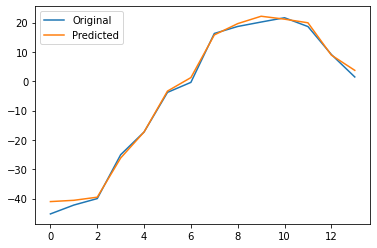

Epoch [13/50], emma_train_loss:1.0771, emma_train_correlation_coefficient:0.4552, Convex_hull_train_loss:0.0379, emma_validation_loss:1.0730, emma_validation_correlation_coefficient:0.4800, Convex_hull_val_loss:0.0381, emma_test_loss:1.0730, emma_test_correlation_coefficient:0.4800, Convex_hull_test_loss:0.0381


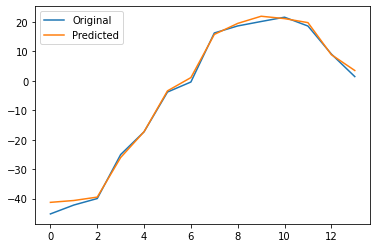

Epoch [14/50], emma_train_loss:1.0639, emma_train_correlation_coefficient:0.4658, Convex_hull_train_loss:0.0370, emma_validation_loss:1.0603, emma_validation_correlation_coefficient:0.4888, Convex_hull_val_loss:0.0373, emma_test_loss:1.0603, emma_test_correlation_coefficient:0.4888, Convex_hull_test_loss:0.0373


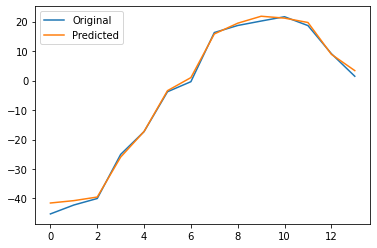

Epoch [15/50], emma_train_loss:1.0512, emma_train_correlation_coefficient:0.4753, Convex_hull_train_loss:0.0365, emma_validation_loss:1.0479, emma_validation_correlation_coefficient:0.4968, Convex_hull_val_loss:0.0365, emma_test_loss:1.0479, emma_test_correlation_coefficient:0.4968, Convex_hull_test_loss:0.0365


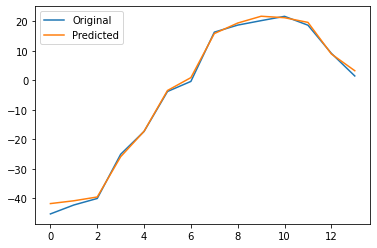

Epoch [16/50], emma_train_loss:1.0412, emma_train_correlation_coefficient:0.4839, Convex_hull_train_loss:0.0357, emma_validation_loss:1.0380, emma_validation_correlation_coefficient:0.5041, Convex_hull_val_loss:0.0357, emma_test_loss:1.0380, emma_test_correlation_coefficient:0.5041, Convex_hull_test_loss:0.0357


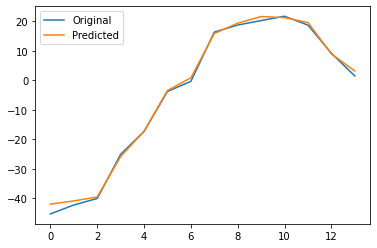

Epoch [17/50], emma_train_loss:1.0302, emma_train_correlation_coefficient:0.4919, Convex_hull_train_loss:0.0346, emma_validation_loss:1.0271, emma_validation_correlation_coefficient:0.5108, Convex_hull_val_loss:0.0344, emma_test_loss:1.0271, emma_test_correlation_coefficient:0.5108, Convex_hull_test_loss:0.0344


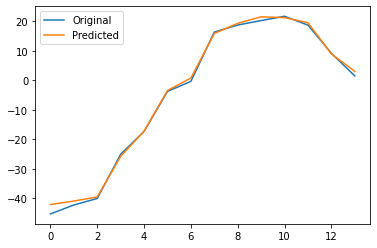

Epoch [18/50], emma_train_loss:1.0195, emma_train_correlation_coefficient:0.4992, Convex_hull_train_loss:0.0328, emma_validation_loss:1.0164, emma_validation_correlation_coefficient:0.5170, Convex_hull_val_loss:0.0325, emma_test_loss:1.0164, emma_test_correlation_coefficient:0.5170, Convex_hull_test_loss:0.0325


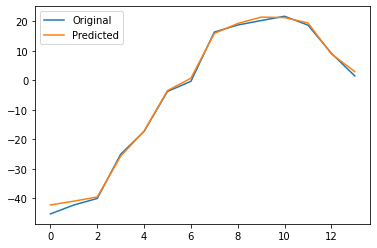

Epoch [19/50], emma_train_loss:1.0088, emma_train_correlation_coefficient:0.5060, Convex_hull_train_loss:0.0314, emma_validation_loss:1.0058, emma_validation_correlation_coefficient:0.5227, Convex_hull_val_loss:0.0311, emma_test_loss:1.0058, emma_test_correlation_coefficient:0.5227, Convex_hull_test_loss:0.0311


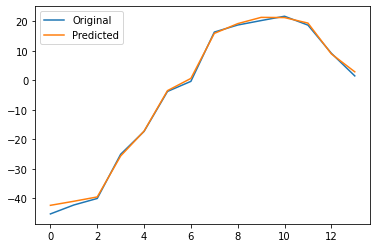

Epoch [20/50], emma_train_loss:0.9994, emma_train_correlation_coefficient:0.5123, Convex_hull_train_loss:0.0294, emma_validation_loss:0.9967, emma_validation_correlation_coefficient:0.5281, Convex_hull_val_loss:0.0290, emma_test_loss:0.9967, emma_test_correlation_coefficient:0.5281, Convex_hull_test_loss:0.0290


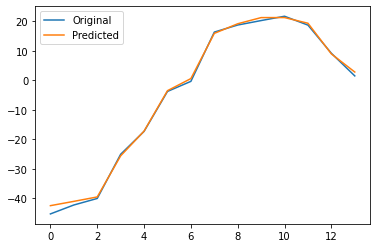

Epoch [21/50], emma_train_loss:0.9915, emma_train_correlation_coefficient:0.5182, Convex_hull_train_loss:0.0272, emma_validation_loss:0.9888, emma_validation_correlation_coefficient:0.5332, Convex_hull_val_loss:0.0266, emma_test_loss:0.9888, emma_test_correlation_coefficient:0.5332, Convex_hull_test_loss:0.0266


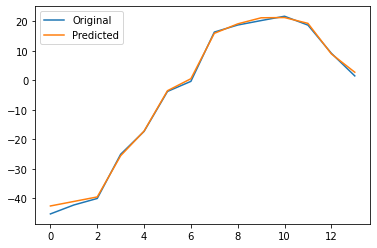

Epoch [22/50], emma_train_loss:0.9841, emma_train_correlation_coefficient:0.5236, Convex_hull_train_loss:0.0246, emma_validation_loss:0.9817, emma_validation_correlation_coefficient:0.5379, Convex_hull_val_loss:0.0240, emma_test_loss:0.9817, emma_test_correlation_coefficient:0.5379, Convex_hull_test_loss:0.0240


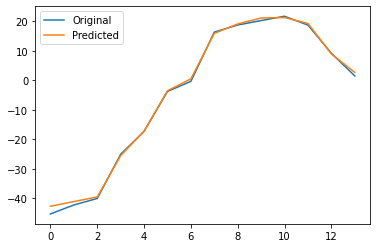

Epoch [23/50], emma_train_loss:0.9772, emma_train_correlation_coefficient:0.5288, Convex_hull_train_loss:0.0218, emma_validation_loss:0.9749, emma_validation_correlation_coefficient:0.5423, Convex_hull_val_loss:0.0212, emma_test_loss:0.9749, emma_test_correlation_coefficient:0.5423, Convex_hull_test_loss:0.0212


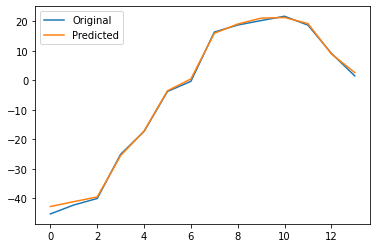

Epoch [24/50], emma_train_loss:0.9705, emma_train_correlation_coefficient:0.5336, Convex_hull_train_loss:0.0187, emma_validation_loss:0.9682, emma_validation_correlation_coefficient:0.5465, Convex_hull_val_loss:0.0180, emma_test_loss:0.9682, emma_test_correlation_coefficient:0.5465, Convex_hull_test_loss:0.0180


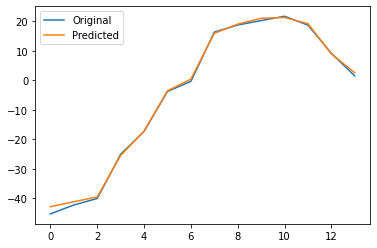

Epoch [25/50], emma_train_loss:0.9641, emma_train_correlation_coefficient:0.5381, Convex_hull_train_loss:0.0159, emma_validation_loss:0.9617, emma_validation_correlation_coefficient:0.5504, Convex_hull_val_loss:0.0151, emma_test_loss:0.9617, emma_test_correlation_coefficient:0.5504, Convex_hull_test_loss:0.0151


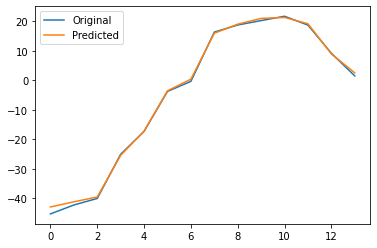

Epoch [26/50], emma_train_loss:0.9588, emma_train_correlation_coefficient:0.5424, Convex_hull_train_loss:0.0129, emma_validation_loss:0.9566, emma_validation_correlation_coefficient:0.5542, Convex_hull_val_loss:0.0123, emma_test_loss:0.9566, emma_test_correlation_coefficient:0.5542, Convex_hull_test_loss:0.0123


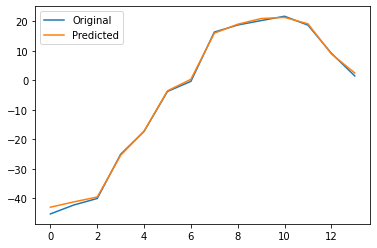

Epoch [27/50], emma_train_loss:0.9540, emma_train_correlation_coefficient:0.5464, Convex_hull_train_loss:0.0107, emma_validation_loss:0.9514, emma_validation_correlation_coefficient:0.5577, Convex_hull_val_loss:0.0100, emma_test_loss:0.9514, emma_test_correlation_coefficient:0.5577, Convex_hull_test_loss:0.0100


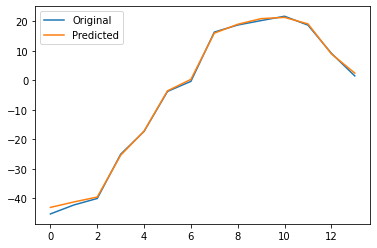

Epoch [28/50], emma_train_loss:0.9484, emma_train_correlation_coefficient:0.5502, Convex_hull_train_loss:0.0089, emma_validation_loss:0.9459, emma_validation_correlation_coefficient:0.5610, Convex_hull_val_loss:0.0084, emma_test_loss:0.9459, emma_test_correlation_coefficient:0.5610, Convex_hull_test_loss:0.0084


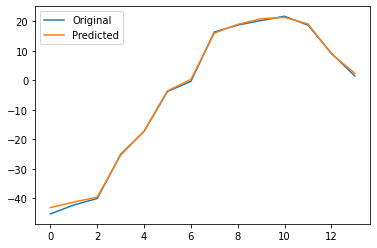

Epoch [29/50], emma_train_loss:0.9443, emma_train_correlation_coefficient:0.5539, Convex_hull_train_loss:0.0071, emma_validation_loss:0.9417, emma_validation_correlation_coefficient:0.5641, Convex_hull_val_loss:0.0066, emma_test_loss:0.9417, emma_test_correlation_coefficient:0.5641, Convex_hull_test_loss:0.0066


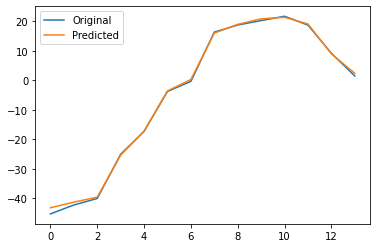

Epoch [30/50], emma_train_loss:0.9395, emma_train_correlation_coefficient:0.5573, Convex_hull_train_loss:0.0059, emma_validation_loss:0.9370, emma_validation_correlation_coefficient:0.5671, Convex_hull_val_loss:0.0054, emma_test_loss:0.9370, emma_test_correlation_coefficient:0.5671, Convex_hull_test_loss:0.0054


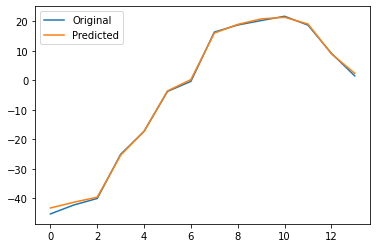

Epoch [31/50], emma_train_loss:0.9359, emma_train_correlation_coefficient:0.5606, Convex_hull_train_loss:0.0051, emma_validation_loss:0.9332, emma_validation_correlation_coefficient:0.5700, Convex_hull_val_loss:0.0047, emma_test_loss:0.9332, emma_test_correlation_coefficient:0.5700, Convex_hull_test_loss:0.0047


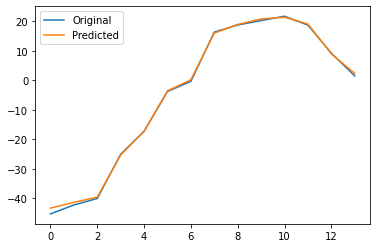

Epoch [32/50], emma_train_loss:0.9315, emma_train_correlation_coefficient:0.5637, Convex_hull_train_loss:0.0045, emma_validation_loss:0.9291, emma_validation_correlation_coefficient:0.5727, Convex_hull_val_loss:0.0041, emma_test_loss:0.9291, emma_test_correlation_coefficient:0.5727, Convex_hull_test_loss:0.0041


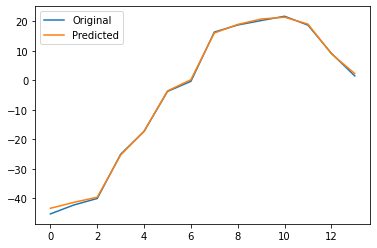

Epoch [33/50], emma_train_loss:0.9283, emma_train_correlation_coefficient:0.5666, Convex_hull_train_loss:0.0041, emma_validation_loss:0.9259, emma_validation_correlation_coefficient:0.5754, Convex_hull_val_loss:0.0038, emma_test_loss:0.9259, emma_test_correlation_coefficient:0.5754, Convex_hull_test_loss:0.0038


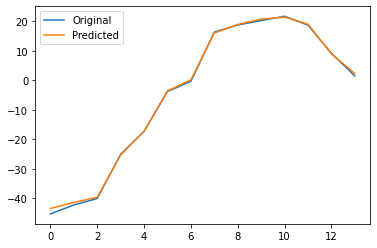

Epoch [34/50], emma_train_loss:0.9244, emma_train_correlation_coefficient:0.5695, Convex_hull_train_loss:0.0038, emma_validation_loss:0.9223, emma_validation_correlation_coefficient:0.5778, Convex_hull_val_loss:0.0034, emma_test_loss:0.9223, emma_test_correlation_coefficient:0.5778, Convex_hull_test_loss:0.0034


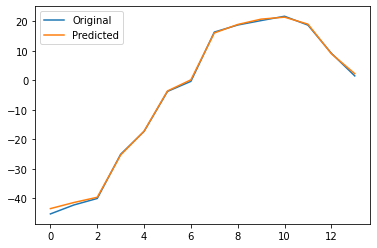

Epoch [35/50], emma_train_loss:0.9215, emma_train_correlation_coefficient:0.5722, Convex_hull_train_loss:0.0036, emma_validation_loss:0.9193, emma_validation_correlation_coefficient:0.5802, Convex_hull_val_loss:0.0033, emma_test_loss:0.9193, emma_test_correlation_coefficient:0.5802, Convex_hull_test_loss:0.0033


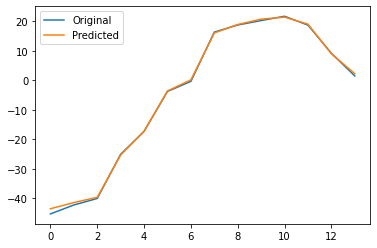

Epoch [36/50], emma_train_loss:0.9179, emma_train_correlation_coefficient:0.5748, Convex_hull_train_loss:0.0035, emma_validation_loss:0.9159, emma_validation_correlation_coefficient:0.5825, Convex_hull_val_loss:0.0031, emma_test_loss:0.9159, emma_test_correlation_coefficient:0.5825, Convex_hull_test_loss:0.0031


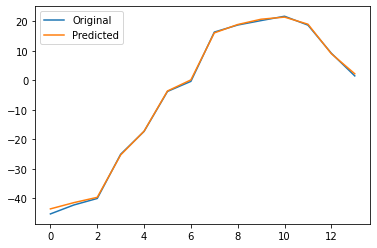

Epoch [37/50], emma_train_loss:0.9155, emma_train_correlation_coefficient:0.5773, Convex_hull_train_loss:0.0034, emma_validation_loss:0.9134, emma_validation_correlation_coefficient:0.5847, Convex_hull_val_loss:0.0031, emma_test_loss:0.9134, emma_test_correlation_coefficient:0.5847, Convex_hull_test_loss:0.0031


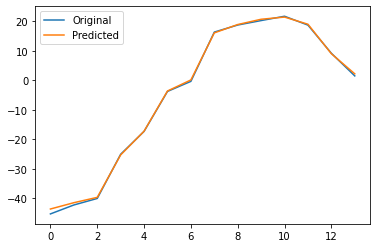

Epoch [38/50], emma_train_loss:0.9121, emma_train_correlation_coefficient:0.5797, Convex_hull_train_loss:0.0032, emma_validation_loss:0.9102, emma_validation_correlation_coefficient:0.5868, Convex_hull_val_loss:0.0028, emma_test_loss:0.9102, emma_test_correlation_coefficient:0.5868, Convex_hull_test_loss:0.0028


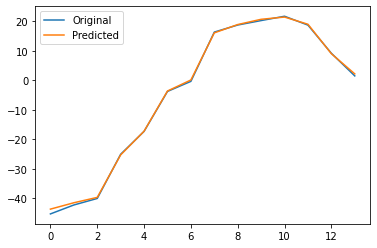

Epoch [39/50], emma_train_loss:0.9100, emma_train_correlation_coefficient:0.5820, Convex_hull_train_loss:0.0032, emma_validation_loss:0.9081, emma_validation_correlation_coefficient:0.5889, Convex_hull_val_loss:0.0028, emma_test_loss:0.9081, emma_test_correlation_coefficient:0.5889, Convex_hull_test_loss:0.0028


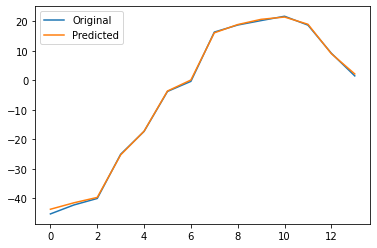

Epoch [40/50], emma_train_loss:0.9068, emma_train_correlation_coefficient:0.5842, Convex_hull_train_loss:0.0032, emma_validation_loss:0.9050, emma_validation_correlation_coefficient:0.5908, Convex_hull_val_loss:0.0028, emma_test_loss:0.9050, emma_test_correlation_coefficient:0.5908, Convex_hull_test_loss:0.0028


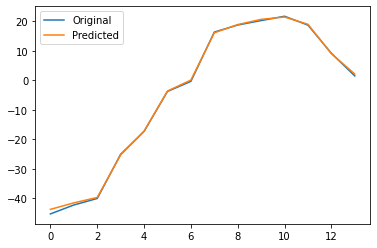

Epoch [41/50], emma_train_loss:0.9051, emma_train_correlation_coefficient:0.5863, Convex_hull_train_loss:0.0030, emma_validation_loss:0.9032, emma_validation_correlation_coefficient:0.5927, Convex_hull_val_loss:0.0027, emma_test_loss:0.9032, emma_test_correlation_coefficient:0.5927, Convex_hull_test_loss:0.0027


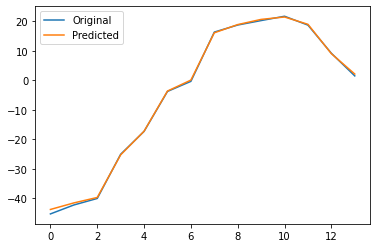

Epoch [42/50], emma_train_loss:0.9020, emma_train_correlation_coefficient:0.5884, Convex_hull_train_loss:0.0029, emma_validation_loss:0.9004, emma_validation_correlation_coefficient:0.5945, Convex_hull_val_loss:0.0025, emma_test_loss:0.9004, emma_test_correlation_coefficient:0.5945, Convex_hull_test_loss:0.0025


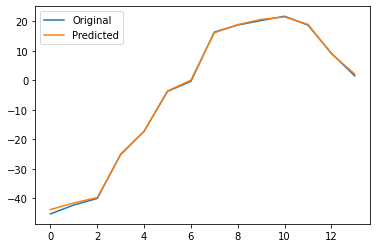

Epoch [43/50], emma_train_loss:0.9002, emma_train_correlation_coefficient:0.5904, Convex_hull_train_loss:0.0030, emma_validation_loss:0.8986, emma_validation_correlation_coefficient:0.5963, Convex_hull_val_loss:0.0026, emma_test_loss:0.8986, emma_test_correlation_coefficient:0.5963, Convex_hull_test_loss:0.0026


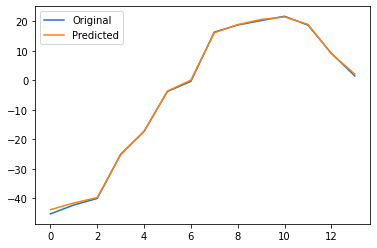

Epoch [44/50], emma_train_loss:0.8971, emma_train_correlation_coefficient:0.5923, Convex_hull_train_loss:0.0029, emma_validation_loss:0.8957, emma_validation_correlation_coefficient:0.5980, Convex_hull_val_loss:0.0025, emma_test_loss:0.8957, emma_test_correlation_coefficient:0.5980, Convex_hull_test_loss:0.0025


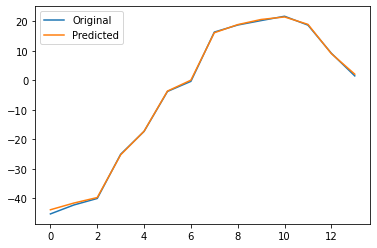

Epoch [45/50], emma_train_loss:0.8957, emma_train_correlation_coefficient:0.5942, Convex_hull_train_loss:0.0030, emma_validation_loss:0.8941, emma_validation_correlation_coefficient:0.5997, Convex_hull_val_loss:0.0025, emma_test_loss:0.8941, emma_test_correlation_coefficient:0.5997, Convex_hull_test_loss:0.0025


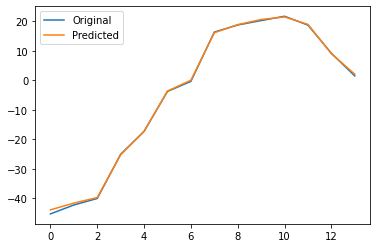

Epoch [46/50], emma_train_loss:0.8929, emma_train_correlation_coefficient:0.5960, Convex_hull_train_loss:0.0028, emma_validation_loss:0.8915, emma_validation_correlation_coefficient:0.6013, Convex_hull_val_loss:0.0024, emma_test_loss:0.8915, emma_test_correlation_coefficient:0.6013, Convex_hull_test_loss:0.0024


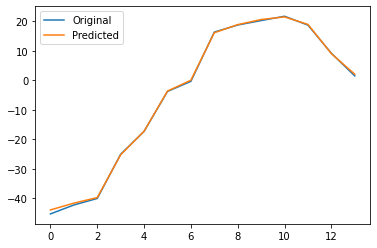

Epoch [47/50], emma_train_loss:0.8913, emma_train_correlation_coefficient:0.5977, Convex_hull_train_loss:0.0029, emma_validation_loss:0.8899, emma_validation_correlation_coefficient:0.6028, Convex_hull_val_loss:0.0025, emma_test_loss:0.8899, emma_test_correlation_coefficient:0.6028, Convex_hull_test_loss:0.0025


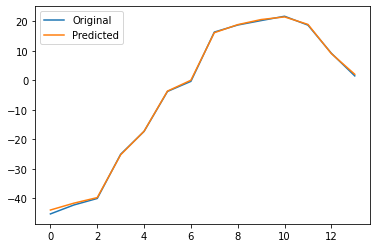

Epoch [48/50], emma_train_loss:0.8888, emma_train_correlation_coefficient:0.5994, Convex_hull_train_loss:0.0028, emma_validation_loss:0.8874, emma_validation_correlation_coefficient:0.6043, Convex_hull_val_loss:0.0023, emma_test_loss:0.8874, emma_test_correlation_coefficient:0.6043, Convex_hull_test_loss:0.0023


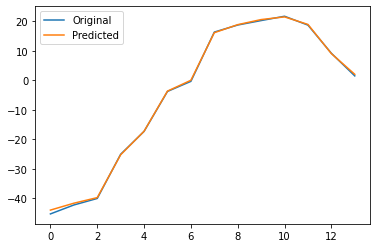

Epoch [49/50], emma_train_loss:0.8876, emma_train_correlation_coefficient:0.6010, Convex_hull_train_loss:0.0028, emma_validation_loss:0.8863, emma_validation_correlation_coefficient:0.6058, Convex_hull_val_loss:0.0024, emma_test_loss:0.8863, emma_test_correlation_coefficient:0.6058, Convex_hull_test_loss:0.0024


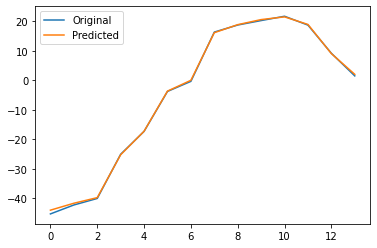

Epoch [50/50], emma_train_loss:0.8848, emma_train_correlation_coefficient:0.6026, Convex_hull_train_loss:0.0029, emma_validation_loss:0.8835, emma_validation_correlation_coefficient:0.6072, Convex_hull_val_loss:0.0024, emma_test_loss:0.8835, emma_test_correlation_coefficient:0.6072, Convex_hull_test_loss:0.0024


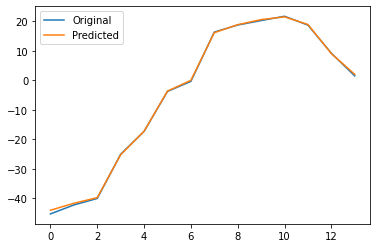

50


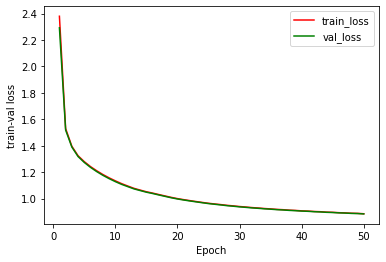

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
  
        self.layer1 = nn.Conv1d(in_channels = 13, out_channels = 32, kernel_size = 3, padding = 1)
        self.layer2 = nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.layer3 = nn.Conv1d(in_channels = 64, out_channels = 256, kernel_size = 3, padding = 1)
        self.layer4 = nn.Conv1d(in_channels = 256, out_channels = 12, kernel_size = 3, padding = 1)
        self.layer5 = nn.Linear(in_features=256, out_features=14)
        self.relu = torch.nn.ReLU()
        
             

    def forward(self, x):
      x = x.permute(0,2,1)
      x = self.layer1(x)
      x = self.relu(x)
      x = self.layer2(x)
      x = self.relu(x)
      x = self.layer3(x)
      x = self.relu(x)
      emma = self.layer4(x)
      x = torch.mean(x, dim=2)
      x = self.layer5(x)
      emma = emma.permute(0, 2, 1)
      return emma, x

model = Net()
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
epochs = 50
mean_train_pearsonr = 0
mean_val_pearsonr = 0 
mean_test_pearsonr = 0
mean_co_train = []
mean_co_val = []
mean_co_test = []
TL = []
VL = []
con_pred = []


for epoch in range (epochs):
  model.train()
  train_emma_loss = 0
  train_convex_hull_loss = 0
  for emma, mfcc in train_dl:
    model = model.float()
    emma = emma.float()
    mfcc = mfcc.float()
    optimizer.zero_grad()
    emma_pred, convex_hull_pred = model(mfcc)
    con_pred.append(convex_hull_pred)

    train_emma_loss = loss(emma_pred, emma)
    train_convex_hull_loss = loss(convex_hull_pred, torch.Tensor(convex_hull))
    t_loss = train_emma_loss + train_convex_hull_loss
    pred_ema = emma_pred.detach()
    true_ema = emma.detach()
    correlations = []
    for i in range(pred_ema.shape[2]):
      corr,_ = pearsonr(true_ema[0,:,i], pred_ema[0,:,i])
      correlations.append(corr)
    mean_corr = np.mean(correlations)
    mean_co_train.append(mean_corr)  
    t_loss.backward()
    optimizer.step()
    train_emma_loss += train_emma_loss.item()
    train_convex_hull_loss += train_convex_hull_loss.item()


  model.eval()  
  val_emma_loss = 0
  val_convex_hull_loss = 0
  with torch.no_grad():
     for emma, mfcc in train_dl:
        model = model.float()
        emma = emma.float()
        mfcc = mfcc.float()
        optimizer.zero_grad()
        emma_pred, convex_hull_pred = model(mfcc)

        val_emma_loss = loss(emma_pred, emma)
        val_convex_hull_loss = loss(convex_hull_pred, torch.Tensor(convex_hull))
        t_loss = val_emma_loss + val_convex_hull_loss
        pred_ema = emma_pred.detach()
        true_ema = emma.detach()
        correlations = []
        for i in range(pred_ema.shape[2]):
            corr,_ = pearsonr(true_ema[0,:,i], pred_ema[0,:,i])
            correlations.append(corr)
        mean_corr = np.mean(correlations)
        mean_co_val.append(mean_corr)  
        val_emma_loss += val_emma_loss.item()
        val_convex_hull_loss += val_convex_hull_loss.item()

  test_emma_loss = 0
  test_convex_hull_loss = 0
  with torch.no_grad():
     for emma, mfcc in train_dl:
        model = model.float()
        emma = emma.float()
        mfcc = mfcc.float()
        optimizer.zero_grad()
        emma_pred, convex_hull_pred = model(mfcc)

        test_emma_loss = loss(emma_pred, emma)
        test_convex_hull_loss = loss(convex_hull_pred, torch.Tensor(convex_hull))
        t_loss = test_emma_loss + test_convex_hull_loss
        pred_ema = emma_pred.detach()
        true_ema = emma.detach()
        correlations = []
        for i in range(pred_ema.shape[2]):
            corr,_ = pearsonr(true_ema[0,:,i], pred_ema[0,:,i])
            correlations.append(corr)
        mean_corr = np.mean(correlations)
        mean_co_test.append(mean_corr)  
        test_emma_loss += test_emma_loss.item()
        test_convex_hull_loss += test_convex_hull_loss.item()
    
  
  mean_train_pearsonr = np.mean(mean_co_train)   
  mean_val_pearsonr = np.mean(mean_co_val)  
  mean_test_pearsonr = np.mean(mean_co_test)  
  
  conv_pred = torch.stack(con_pred)
  av_conv_pred = torch.mean(conv_pred, dim = 0)
  print('Epoch [{}/{}], emma_train_loss:{:.4f}, emma_train_correlation_coefficient:{:.4f}, Convex_hull_train_loss:{:.4f}, emma_validation_loss:{:.4f}, emma_validation_correlation_coefficient:{:.4f}, Convex_hull_val_loss:{:.4f}, emma_test_loss:{:.4f}, emma_test_correlation_coefficient:{:.4f}, Convex_hull_test_loss:{:.4f}'.format(epoch+1, epochs, train_emma_loss, mean_train_pearsonr, train_convex_hull_loss, val_emma_loss, mean_val_pearsonr, val_convex_hull_loss, test_emma_loss, mean_test_pearsonr, test_convex_hull_loss))
  with torch.no_grad():
     convex_hull_pred_mean = torch.mean(av_conv_pred, dim=0).numpy()
     convex_hull_pred_mean_rescaled = (convex_hull_pred_mean * std) + mean  
     plt.plot(CH, label='Original')
     plt.plot(convex_hull_pred_mean_rescaled, label='Predicted')
     plt.legend()
     plt.show()
 
  TL.append(train_emma_loss)
  VL.append(val_emma_loss)

print(len(TL))
with torch.no_grad():
   ep = range(1, epochs+1)
   plt.plot(ep, TL, color = 'r', label = 'train_loss' )
   plt.plot(ep, VL, color = 'g', label = 'val_loss' )
   plt.xlabel('Epoch')
   plt.ylabel('train-val loss')
   plt.legend()
   plt.show()

